In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import nbinom

In [78]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import urllib.request, json
import datetime
from scipy import stats


def get_stock_data(name):
    # https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AMZN&interval=60min&apikey=D8N9ZL5YTPIWAD99
    with urllib.request.urlopen('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=%s&interval=1min&apikey=D8N9ZL5YTPIWAD99' % name) as url:
        data = json.loads(url.read().decode())
        if 'Error Message' in data:
            print('Service is not available')
            dates = []
            x = []
        else:
            dates = []
            x = []
            all_data = list(data['Time Series (1min)'].keys())
            for data_point in all_data:
                dates.append(datetime.datetime.strptime(data_point, '%Y-%m-%d %H:%M:%S'))
                #print(data['Time Series (1min)'][data_point]['4. close'])
                x.append(float(data['Time Series (1min)'][data_point]['4. close']))
        #x=[float(price)]
        #dates=[datetime.datetime.strptime(last_date, '%Y-%m-%d %H:%M:%S')]
    return x,dates

def plot_data(i):
    x_dates = get_stock_data(stock_symbol)
    x_data_new = []
    for x_id, x_date in enumerate(x_dates[0]):
        if(x_id > 0):
            x_data_new.append((x_date/x_dates[0][x_id-1])-1)
    ax.clear()
    #ax.plot_date(x_dates[1], x_dates[0], markersize=0.5)
    ax.plot_date(x_dates[1][1:], x_data_new,'b-', markersize=0.5)

#AMZN
#MSFT
#AAPL
stock_symbol='AAPL'

fig = plt.figure(figsize=(2**20,2**20))
ax = fig.add_subplot(1,1,1)

#describe_data(get_stock_data(stock_symbol))

#ask for new data every 20 seconds
ani = animation.FuncAnimation(fig, plot_data, interval=20000)
plt.show()


ValueError: Image size of 75497472x75497472 pixels is too large. It must be less than 2^16 in each direction.

In [64]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data, partition

def generate_poisson_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        lamb = np.abs(np.random.randn()*10)
        tdata = np.random.poisson(lamb, p)
        data = np.concatenate((data, tdata))
    return data, partition


In [45]:
#Read and plot data

DIR_FILENAME = 'dowj_1996-2018.csv'
#dataset = np.genfromtxt(DIR_FILENAME, delimiter=',')


dataset_n, part_n = generate_normal_time_series(8, 50, 200)
dataset_p, part_p = generate_poisson_time_series(8, 50, 200)

In [16]:
#Define functions

def const_hazard(r,lambda_):
    probs = np.ones(r)/lambda_
    return probs

def pred_prob(x,mu,alpha,kappa,beta,dist):
    if dist=='norm':
        center = mu
        precision = (alpha*kappa)/(beta*(kappa+1))
        deg_freedom = 2*alpha
        pred = t.pdf(x, df= deg_freedom, loc= center,scale= np.sqrt(precision))
        
    if dist=='poisson':
        mu = alpha/beta
        var = (alpha/(beta**2))*(beta+1)
        prob = (var**2- mu)/(var**2)
        num =   1    
        pred = nbinom.pmf(x, n = num, p = prob)
        
    return pred

def update_stats(x,mu,alpha,kappa,beta,dist):
    if dist =='norm':
        mu, alpha, kappa, beta = (kappa*mu + x) / (kappa+1.), alpha+0.5, kappa+1., beta +(kappa*(x-mu)**2)/(2*(kappa+1.))
    if dist == 'poisson':
        alpha, beta = alpha + x , beta+1
    return mu, alpha, kappa, beta


In [24]:
def inference(data, mu0 = 0, kappa0 = 1, alpha0= 0.1, beta0= 0.01, lam = [20], dist='norm'):
    #Initialize
    prob_r = np.zeros((len(data) + 1, len(data) + 1))
    prob_r[0, 0] = 1
    mu, kappa, alpha, beta = np.array([mu0]), np.array([kappa0]), np.array([alpha0]), np.array([beta0])
    
    #Start iteration   
    for t,x in enumerate(data):      
        #Calculate predictive probability for new data point
        pred = pred_prob(x,mu,alpha,kappa,beta,dist)
        
        #Calculate growth probability 
        prob_r[1:t+2,t+1] = prob_r[:t+1,t]* pred * (1-const_hazard(t+1,lam))

        #Calculate changepoint probability
        prob_r[0,t+1] = np.sum( prob_r[:t+1,t] * pred * const_hazard(t+1,lam))
        
        #Calculate evidence
        sum_prob_r =  np.sum(prob_r[:,t+1])
        
        #Run length distribution
        prob_r[:,t+1] /= sum_prob_r
        
        #Update sufficient statistics
        mu_n, alpha_n, kappa_n, beta_n = update_stats(x, mu, alpha, kappa, beta,dist) 
        mu, kappa, alpha, beta = np.append(np.array([mu0]), mu_n), np.append(np.array([kappa0]), kappa_n), np.append(np.array([alpha0]), alpha_n), np.append(np.array([beta0]), beta_n) 
    
        
    return prob_r

In [59]:
p = inference(dataset_p)

/home/esraz/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:3845: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/esraz/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:3845: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


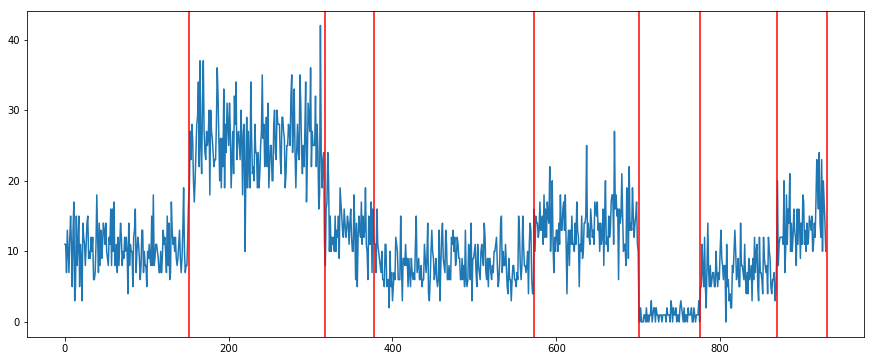

In [55]:
# plot
fig = plt.figure(figsize=(15,6))
plt.plot(dataset_p)
for cp in np.cumsum(part_p):
    plt.axvline(x=cp, color='r')

plt.show()

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


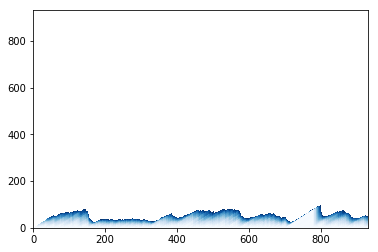

In [60]:
plt.figure()
plt.imshow(-np.log(p), interpolation='none', aspect='auto',
origin='lower', cmap=plt.cm.Blues)
plt.show()